In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
from __future__ import annotations
import networkx as nx
import jaxley as jx
from jaxley.io.swc import read_swc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# TODOS:

### change order of nodes and edges
- Nodes: idx, indices (int), groups (bool), morph_attrs, channel_attrs, other_attrs (set_by)
- Edges: idx, indices (int), synapses (bool), morph_attrs, channel_attrs, other_attrs (set_by)

### Reformat dataframes
- rename `global_X_index` to `X_index`
- use tuples of nodes to index edges
- treat synapses like groups and channels, i.e. boolean indices

### Pass tests
- pass import / export cycle tests
- pass `test_swc.py`

### Remove group_names from global graph attrs
- group_names can be inferred from nodes, i.e. names of boolean cols which are not channels.


### Keep branchpoints and tip nodes in `nodes` and in graph
- introduce `compartments` attribute that only shows compartment nodes? Nodes shows all nodes `cell.nodes.loc[is_comp]`

### Refactor graph editing functions in `morph_utils`
- with the new graph functionality, this should be much easier to do

### Refactor `compute_xyz` function
- replace old `compute_xyz` with new version

### Refactor `set_ncomp`
- `set_ncomp` should be much simpler via `branch_comps_from_nodes`

In [4]:
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new

import networkx as nx
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import jax

import warnings

In [198]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Circle

def graph_vis(graph, dims=(0, 1), ax=None, show_radii=False, jitter=0.0, scale_radii=1.0, radii_kwargs={}, **kwargs):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))

    add_jitter = lambda x: x + np.random.uniform(-jitter, jitter, size=len(x))
    pos = {
        k: add_jitter(np.array([data["xyz"[d]] for d in dims]))
        for k, data in graph.nodes(data=True)
    }

    nx.draw(graph, pos=pos, ax=ax, **kwargs)

    if show_radii:
        patch_kwargs = dict(edgecolor="C3", facecolor="none", linewidth=1.0, zorder=3)
        patch_kwargs.update(radii_kwargs)

        for k, data in graph.nodes(data=True):
            r = data.get("radius", data.get("r", None))
            R = float(r) * float(scale_radii)
            ax.add_patch(Circle(pos[k], R, **patch_kwargs))

        ax.set_aspect("equal", adjustable="box")

    return ax

In [344]:
import numpy as np
from neuron import h
from neuron import rxd
import jaxley.io.graph as graph_io_old
import jaxley.io.tmp as graph_io_new
from scipy.spatial.distance import cdist
from typing import Callable, Optional
import jax
import jax.numpy as jnp
import pandas as pd

unpack_dict = lambda d, keys: np.array([d[k] for k in keys])

def neuron_swc_reader(fname: str, ncomp: int = 1):
    """
    Load a SWC file and return a NEURON cell object.

    Uses `h.Import3d_SWC_read()` to load the SWC file.

    Args:
        fname: The path to the SWC file.
        ncomp: The number of compartments per segment.
    """
    # Load NEURON stdlib and import3d
    h.load_file("stdlib.hoc")
    h.load_file("import3d.hoc")

    # Clear existing sections
    for sec in h.allsec():
        h.delete_section(sec=sec)

    # Load and instantiate SWC
    cell = h.Import3d_SWC_read()
    cell.input(fname)
    i3d = h.Import3d_GUI(cell, False)
    i3d.instantiate(None)

    for sec in h.allsec():
        sec.nseg = ncomp

    return cell


def neuron_swc_graph() -> nx.DiGraph:
    """
    Reads from the global `h.allsec()` and writes the attributes to a nx.DiGraph. The 
    edges are created by connecting the first point of a section to the last point of the
    parent section and connecting up each point (line in the SWC file) within a section.
    Each n3d point becomes a node in the graph. 

    The graph is comparable to Jaxley's SWC-Graph and can be used to compare / debug 
    Jaxley's and NEURON's SWC readers.
    
    The node attributes are:
    - node: The node index.
    - id: The SWC type ID.
    - x: The x-coordinate.
    - y: The y-coordinate.
    - z: The z-coordinate.
    - r: The radius.
    - parent_id: The index of the parent node.
    - sec_name: The name of the section.

    Returns:
        A nx.DiGraph with the node and edge attributes.
    """
    points = []
    id_counter = 1  # SWC IDs start at 1

    # Map section types to SWC type IDs
    type_map = {
        'soma': 1,
        'axon': 2,
        'dend': 3,
        'apic': 4
    }

    # Keep track of last point ID in each section for connectivity
    section_last_point_id = {}

    for sec in h.allsec():
        sec_name = sec.name()
        # Determine SWC type by checking the prefix of section name
        swc_type = 3  # default dendrite
        for key in type_map:
            if sec_name.startswith(key):
                swc_type = type_map[key]
                break

        n3d = int(h.n3d(sec=sec))
        if n3d == 0:
            continue

        for i in range(n3d):
            x = h.x3d(i, sec=sec)
            y = h.y3d(i, sec=sec)
            z = h.z3d(i, sec=sec)
            radius = h.diam3d(i, sec=sec) / 2

            if i == 0:
                # Parent id is the last point id of the parent section if exists
                sec_ref = h.SectionRef(sec=sec)
                if sec_ref.has_parent():
                    parent_sec = sec_ref.parent
                    parent_point_id = section_last_point_id.get(parent_sec.name(), -1)
                else:
                    parent_point_id = -1
            else:
                # Parent is previous point in the same section
                parent_point_id = id_counter - 1

            points.append({
                'node': id_counter,
                'id': swc_type,
                'x': x,
                'y': y,
                'z': z,
                'r': radius,
                'parent_id': parent_point_id,
                'sec_name': sec_name,
            })
            id_counter += 1

        # Save last point id of this section for parent linkage
        section_last_point_id[sec_name] = id_counter - 1

    nodes_df = pd.DataFrame(points)
    nodes_df.set_index("node", inplace=True)
    nodes_df.index.name = None

    edges_df = nodes_df[["parent_id"]].copy()
    edges_df["target"] = nodes_df.index
    edges_df = edges_df[edges_df["parent_id"] != -1]
    edges_df.set_index(["parent_id", "target"], inplace=True)
    edges_df.index.names = (None, None)

    nodes_df.drop(columns=["parent_id"], inplace=True)

    return graph_io_new.pandas_to_nx(nodes_df, edges_df, pd.Series())


def neuron_solve_graph(ncomp: int = 1, drop_neuron_specific_attrs: bool = True) -> nx.DiGraph:
    """
    Reads from the global `h.allsec()` and constructs a compartment graph from the ingested
    SWC file. Each section is divided into `ncomp` compartments and each compartment will
    become a node in the graph. Each node will contain the attributes that are used to
    simulate each compartment.

    The graph is comparable to Jaxley's Compartment-Graph and can be used to compare / debug 
    Jaxley's and NEURON's SWC readers. Especially how NEURON and Jaxley handle computation
    of the compartment / segment attributes, like radius, volume, surface area, etc.

    The node attributes are:
    - comp_index: The compartment index.
    - seg_name: The name of the segment. (neuron specific)
    - sec_name: The name of the section. (neuron specific)
    - x: The x-coordinate.
    - y: The y-coordinate.
    - z: The z-coordinate.
    - radius: The radius.
    - area: The area.
    - surface_area: The surface area.
    - volume: The volume.
    - length: The length.
    - groups: The groups.

    Returns:
        A nx.DiGraph with the node and edge attributes.
    """
    for sec in h.allsec():
        sec.nseg = ncomp

    data = []
    segment_indices = {}
    compartment_index = 0

    type2id = {
        "soma": 1,
        "axon": 2,
        "dend": 3,
        "apic": 4
    }

    # Dummy cytosolic region
    cyt = rxd.Region(h.allsec(), name='cyt')

    # Create a dummy species to get access to segment volumes
    ca = rxd.Species(cyt, name='ca', d=0)

    seg_areas = {str(node.segment): node.surface_area for node in ca.nodes}
    seg_volumes = {str(node.segment): node.volume for node in ca.nodes}

    # collect node data and assign segment indices
    graph_attrs = {"xyzr": [], "branchpoints_and_tips": []}
    seg_edges = []
    for sec in h.allsec():
        bounds = np.linspace(0, 1, sec.nseg+1)
        centers = (bounds[1:] + bounds[:-1]) / 2
        sec_name = sec.name()


        n3d = sec.n3d()
        x3d = np.array([sec.x3d(i) for i in range(n3d)])
        y3d = np.array([sec.y3d(i) for i in range(n3d)])
        z3d = np.array([sec.z3d(i) for i in range(n3d)])
        arc = np.array([sec.arc3d(i) for i in range(n3d)])  # Cumulative arc lengths
        r3d = np.array([sec.diam3d(i) / 2 for i in range(n3d)])
        xyzr = np.array([x3d, y3d, z3d, r3d]).T

        seg_x = np.interp(centers * arc[-1], arc, x3d)
        seg_y = np.interp(centers * arc[-1], arc, y3d)
        seg_z = np.interp(centers * arc[-1], arc, z3d)
        
        seg_names = []
        segment_indices[sec] = []
        for seg_idx, seg in enumerate(sec):
            radius = seg.diam / 2
            length = sec.L / sec.nseg
            type_name = sec_name.split("[")[0]
            seg_name = str(sec(centers[seg_idx]))
            seg_names.append(seg_name)

            data.append({
                "comp_index": compartment_index,
                "seg_name": seg_name,
                "sec_name": sec_name,
                "x": seg_x[seg_idx],
                "y": seg_y[seg_idx],
                "z": seg_z[seg_idx],
                "r": radius,
                "area": seg_areas[seg_name],
                "volume": seg_volumes[seg_name],
                "l": length,
                "id": type2id.get(type_name, "unknown")
            })
            graph_attrs["xyzr"].append(xyzr)

            segment_indices[sec].append(compartment_index)
            compartment_index += 1

        # edges
        if sec.parentseg():
            parent_sec = sec.parentseg().sec
            parent_bounds = np.linspace(0, 1, parent_sec.nseg+1)
            parent_centers = (parent_bounds[1:] + parent_bounds[:-1]) / 2
            prev_sec_end = str(parent_sec(parent_centers[-1]))
            seg_edges += [(prev_sec_end, seg_names[0])] # between branches

        if len(seg_names) > 1:
            seg_edges += [e for e in zip(seg_names[:-1], seg_names[1:])] # within branch

    # Create DataFrames
    nodes_df = pd.DataFrame(data).set_index("comp_index")
    branch_indices = {sec.name(): i for i, sec in enumerate(h.allsec())}
    nodes_df["branch_index"] = nodes_df["sec_name"].map(branch_indices)
    nodes_df["is_comp"] = True
    nodes_df["cell_index"] = 0

    edges_df = pd.DataFrame(seg_edges, columns=["source", "target"])
    edges_df = edges_df[edges_df["source"].notna()]

    name_to_index = dict(zip(nodes_df["seg_name"], nodes_df.index))
    edges_df['source'] = edges_df['source'].map(name_to_index)
    edges_df['target'] = edges_df['target'].map(name_to_index)

    source_branches = nodes_df.loc[edges_df["source"], "branch_index"].values
    target_branches = nodes_df.loc[edges_df["target"], "branch_index"].values
    edges_df["branch_edge"] = (source_branches != target_branches)
    edges_df["comp_edge"] = True
    edges_df["synapse"] = False

    edges_df.set_index(["source", "target"], inplace=True)
    edges_df.index.names = [None, None]

    if drop_neuron_specific_attrs:
        nodes_df = nodes_df.drop(columns=["seg_name", "sec_name"])

    graph = graph_io_new.pandas_to_nx(nodes_df, edges_df, pd.Series(graph_attrs))
    graph = graph_io_new._add_jaxley_meta_data(graph)
    nx.set_node_attributes(graph, {n: int(d["comp_index"]) for n,d in graph.nodes(data=True)}, "comp_index")

    return graph

def neuron_list_branches(swc_graph: nx.DiGraph) -> list[list[int]]:
    """Creates a list of branches / sections from a NEURON SWC graph.

    This returns the compartment indices (same as the node indices in the compartment graph)
    for each branch / section in the NEURON SWC graph.

    Args:
        swc_graph: A NEURON SWC graph (created with `neuron_swc_graph()`).

    Returns:
        A list of lists, where each sublist contains the compartment indices for a branch
        and the index of each list corresponds to the branch index.
    """
    secs = nx.get_node_attributes(swc_graph, "sec_name")
    branches = {k: [] for k in secs.values()}
    for k, v in secs.items():
        branches[v].append(k)
    return list(branches.values())

def old_list_branches(swc_graph, ignore_swc_tracing_interruptions=True):
    traced_branches = []
    mod_graph, branches, *_ = graph_io_old._trace_branches(swc_graph, ignore_swc_tracing_interruptions=ignore_swc_tracing_interruptions)
    for branch in branches:
        traced_branches.append(np.unique(branch[:,:-1].flatten().astype(int)).tolist())
    return traced_branches, mod_graph

def match_branches(input_swc_graph: nx.DiGraph, target_swc_graph: nx.DiGraph, input_branches: list[list[int]], target_branches: list[list[int]], match_on: str = "xyz", tol: float = 1e-3) -> list[list[int]]:
    """Matches the branches in the input graph to the branches in the target graph.

    The returned branch list is ordered in the same way as the target branch list. In
    addition, the branches are made to have the same direction as the target branches.

    Args:
        input_swc_graph: A graph representation of a SWC file.
        target_swc_graph: A graph representation of a SWC file.
        input_branches: A list of lists, where each sublist contains the compartment indices
            for a branch in the input graph.
        target_branches: A list of lists, where each sublist contains the compartment indices
            for a branch in the target graph.
        match_on: The attributes to match on, i.e. ["x", "y", "z"] to match on the x, y, 
            and z coordinates.
        tol: The tolerance for the matching, i.e. 1e-3 considers two nodes to be the same 
            if the distance between them is less than 1e-3.

    Returns:
        The input branches reordered to match the target branches.
    """
    assert len(input_branches) == len(target_branches), "Number of branches is not the same"
    
    input_node_xyz = np.array([unpack_dict(d, match_on) for n, d in input_swc_graph.nodes(data=True)])
    target_node_xyz = np.array([unpack_dict(d, match_on) for n, d in target_swc_graph.nodes(data=True)])

    # find the closest nodes in the input graph and target graph
    dists = cdist(input_node_xyz, target_node_xyz)
    # is_close = np.isclose(dists, 0, atol=tol)
    # input_idx, target_idx = np.where(is_close)
    
    input_idx = np.arange(dists.shape[0])
    target_idx = np.argmin(dists, axis=1)
    dists = np.min(dists, axis=1)
    if tol:
        keep = dists < tol
        input_idx = input_idx[keep]
        target_idx = target_idx[keep]

    # align input and target nodes
    input_nodes = np.array(list(input_swc_graph.nodes()))[input_idx]
    target_nodes = np.array(list(target_swc_graph.nodes()))[target_idx]
    # create a mapping from the input nodes to the target nodes
    input2target = {n_i: n_t for n_i, n_t in zip(input_nodes, target_nodes)}

    # branch index of the target nodes
    branch_of_target_node = {n: np.where([n in b for b in target_branches])[0] for n in sum(target_branches, [])}
    # corresponding branch index of the input nodes in the target graph
    branch_targets = [np.hstack([branch_of_target_node[input2target[n]] for n in b]) for b in input_branches]
    # each node in the input graph, i.e. [[1,2,3,4,5], [...]] has corresponding 
    # branch index in the target graph, i.e. [[0,1,1,1,1,2], [...]] The 
    # corresponding branch index will be assigned based on the most common target branch
    # index for the input nodes, i.e. branch 0 in the input will be assigned to branch 1
    # in the target graph.

    # reorder the input branches to match the target branches
    new_order = np.argsort([max(set(b), key=b.tolist().count) for i, b in enumerate(branch_targets)])
    input_branches = [input_branches[i] for i in new_order]

    # reverse node order of the input branches if they are not in the same direction as 
    # the target branches
    for i, b_in in enumerate(input_branches):
        b_in_start_xyz = unpack_dict(input_swc_graph.nodes[b_in[0]], "xyz")
        b_in_end_xyz = unpack_dict(input_swc_graph.nodes[b_in[-1]], "xyz")
        b_target_start_xyz = unpack_dict(target_swc_graph.nodes[input2target[b_in[0]]], "xyz")
        dist_start2start = np.linalg.norm(b_in_start_xyz - b_target_start_xyz)
        dist_end2start = np.linalg.norm(b_in_end_xyz - b_target_start_xyz)
        if dist_start2start > dist_end2start:
            input_branches[i] = input_branches[i][::-1]

    return input_branches

def match_nodes(input_graph: nx.DiGraph, target_graph: nx.DiGraph, match_on: str = "xyzr", tol: float = 1e-3, assert_unique: bool = True) -> nx.DiGraph:
    """Matches the nodes in the input graph to the nodes in the target graph.

    The returned graph is relabeled such that the corresponding nodes in the input and target
    graph have the same node indices.

    Args:
        input_graph: A graph (either a SWC graph or a compartment graph).
        target_graph: A graph (either a SWC graph or a compartment graph).
        match_on: The attributes to match on, i.e. ["x", "y", "z"] to match on the x, y, 
            and z coordinates.
        tol: The tolerance for the matching, i.e. 1e-3 considers two nodes to be the same 
            if the distance between them is less than 1e-3.
        assert_unique: Whether to assert that the nodes are matched uniquely. If False,
            the nodes not all nodes will have a unique match.

    Returns:
        The input graph relabeled to have the same node indices as the target graph.
    """
    input_nodes = np.array(list(input_graph.nodes()))
    target_nodes = np.array(list(target_graph.nodes()))

    input_node_xyz = np.array([unpack_dict(d, match_on) for n, d in input_graph.nodes(data=True)])
    target_node_xyz = np.array([unpack_dict(d, match_on) for n, d in target_graph.nodes(data=True)])

    # compute pairwise distances between the nodes in the input and target graph
    dists = cdist(input_node_xyz, target_node_xyz)
    # is_close = np.isclose(dists, 0, atol=tol)
    # input_idx, target_idx = np.where(is_close)
    
    # if there is multiple targets for one input, keep the closest target
    input_idx = np.arange(dists.shape[0])
    target_idx = np.argmin(dists, axis=1)
    min_dists = np.min(dists, axis=1)
    if tol:
        keep = min_dists < tol
        input_idx = input_idx[keep]
        target_idx = target_idx[keep]

    if assert_unique:
        # find nodes that are not matched uniquely
        is_close = np.isclose(dists, 0, atol=tol)
        input_counts = np.sum(is_close, axis=1)
        target_counts = np.sum(is_close, axis=0)
        input_inds = np.where(input_counts > 1)[0]
        target_inds = np.where(target_counts > 1)[0]

        assert len(input_graph.nodes()) == len(target_graph.nodes()), "Number of nodes is not the same"
        assert np.all(input_counts == 1), f"Some input nodes were not matched uniquely: {input_nodes[input_inds[input_counts != 1]]}"
        assert np.all(target_counts == 1), f"Some target nodes were not matched uniquely: {target_nodes[target_inds[target_counts != 1]]}"

    old_labels = input_nodes[input_idx].tolist()
    new_labels = target_nodes[target_idx].tolist()
    
    # prevent overlap of new and old labels
    affected_labels = set(old_labels + new_labels) & set(input_nodes)
    tmp_labels = graph_io_new.propose_new_inds(set(input_nodes), len(affected_labels))
    affected2tmp = dict(zip(affected_labels, tmp_labels))
    input_graph = nx.relabel_nodes(input_graph, affected2tmp)

    # relabel nodes on input graph
    tmp2new = dict(zip([affected2tmp[n] for n in old_labels], new_labels))
    input_graph = nx.relabel_nodes(input_graph, tmp2new)

    return input_graph

def match_edges(input_graph, target_graph, raise_if_not_found=True):
    input_edges = input_graph.edges()
    target_edges = target_graph.edges()
    for (i,j) in target_edges:
        if (i,j) in input_edges:
            continue
        elif (j,i) in input_edges:
            edge_attrs = input_graph.edges[(j,i)]
            input_graph.remove_edge(j,i)
            input_graph.add_edge(i,j, **edge_attrs)
        elif raise_if_not_found:
            raise ValueError(f"Could not find edge between {i,j} in input graph")            
    return input_graph

def compare_node_attrs(input_graph: nx.DiGraph, target_graph: nx.DiGraph, key: str, func: Callable = jnp.isclose, reduce: Callable = all, subset: Optional[list[int]] = None):
    """Compares the node attributes of the input and target graph.

    Graphs are compared by their node indices / labels. This means corresponding nodes in the
    input and target graph should have the same node indices. To do this you can use 
    `match_nodes()` to relabel the input graph to have the same node indices as the target 
    graph, before running this function.

    Args:
        input_graph: A graph.
        target_graph: A graph.
        key: The attribute to compare.
        func: The function to use to compare the attributes.
        reduce: The function to use to reduce the comparison results.
        subset: A list of node indices to compare.

    Returns:
        The comparison results.
    """
    if subset is not None:
        input_graph = input_graph.subgraph(subset)
        target_graph = target_graph.subgraph(subset)

    input_attrs = nx.get_node_attributes(input_graph, key)
    target_attrs = nx.get_node_attributes(target_graph, key)
    is_equal = jax.tree_util.tree_map(lambda x, y: func(x, y), input_attrs, target_attrs)
    if reduce is not None:
        return reduce(jnp.array(jax.tree.flatten(is_equal)[0]))
    else:
        return is_equal
    
def print_or_assert(cond, msg, print_only=True):
    if print_only:
        if not cond:
            print(msg)
        else:
            return
    else:
        assert cond, msg

def compute_branch_features(graph, branches):
    def path_lengths(xyz):
        d = np.diff(xyz, axis=0)
        seg = np.linalg.norm(d, axis=1)
        s = np.concatenate([[0.0], np.cumsum(seg)])
        return s

    def length_weighted_mean(values, s):
        L = s[-1]
        return np.trapezoid(values, s) / L if L > 0 else 0.0

    xyzrs = [np.array([unpack_dict(graph.nodes[n], "xyzr") for n in b]) for b in branches]
    ls = [path_lengths(xyzr_i[:, :3]) for xyzr_i in xyzrs]
    branch_lens = [np.sum(l) for l in ls]
    avg_x = [length_weighted_mean(xyzr_i[:, 0], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_y = [length_weighted_mean(xyzr_i[:, 1], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_z = [length_weighted_mean(xyzr_i[:, 2], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]
    avg_radius = [length_weighted_mean(xyzr_i[:, 3], l_i) for xyzr_i, l_i in zip(xyzrs, ls)]

    fts = [branch_lens, avg_x, avg_y, avg_z, avg_radius]
    return np.array([np.hstack(f) for f in zip(*fts)])

In [208]:
def test_swc_reader_matches_neuron(fname: str):
    """Tests that the SWC reader matches NEURON.

    This test has 3 parts:
    1. Test the SWC file is read correctly.
    2. Test Jaxley's branches match NEURON's sections.
    3. Test Jaxley's compartments match NEURON's segments.

    Args:
        fname: The path to the SWC file.
    """
    ### SWC GRAPHS ###
    neuron_swc_reader(fname)
    swc_neuron = neuron_swc_graph()
    # swc_jaxley = graph_io_old.to_swc_graph(fname)

    swc_jaxley = graph_io_new.swc_to_nx(fname)
    swc_neuron_matched = match_nodes(swc_neuron.copy(), swc_jaxley, assert_unique=False)

    for attr in ["x", "y", "z", "r"]:
        nodes_in_both_graphs = set(swc_jaxley.nodes()) & set(swc_neuron_matched.nodes())
        print_or_assert(compare_node_attrs(swc_jaxley, swc_neuron_matched, attr, subset=nodes_in_both_graphs), f"Attribute {attr} is not equal")

    ### BRANCHES ###
    branches_jaxley = graph_io_new.list_branches(swc_jaxley, ignore_swc_tracing_interruptions=False)
    # branches_jaxley = old_list_branches(swc_jaxley, ignore_swc_tracing_interruptions=False)
    branches_neuron = neuron_list_branches(swc_neuron)

    branches_jaxley = match_branches(swc_jaxley, swc_neuron, branches_jaxley, branches_neuron)

    # branch_fts_jaxley = compute_branch_features(swc_jaxley, branches_jaxley)
    # branch_fts_neuron = compute_branch_features(swc_neuron, branches_neuron)

    assert len(branches_jaxley) == len(branches_neuron), "Number of branches is not the same"

    ### COMP GRAPHS ###
    comp_graph_neuron = neuron_comp_graph(ncomp=1)

    comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
    comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)
    comp_graph_jaxley = graph_io_new._replace_branchpoints_with_edges(comp_graph_jaxley)
    groups_from_node_attrs = lambda d: "".join([d.get(g, False)*g for g in ["soma", "basal", "apical", "axon"]])
    nx.set_node_attributes(comp_graph_jaxley, {k: [groups_from_node_attrs(d)] for k, d in comp_graph_jaxley.nodes(data=True)}, "groups")

    # comp_graph_jaxley = graph_io_old.build_compartment_graph(comp_graph_jaxley, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
    # comp_graph_jaxley = graph_io_old._remove_branch_points_at_tips(comp_graph_jaxley)
    # comp_graph_jaxley = graph_io_old._remove_branch_points(comp_graph_jaxley)

    comp_graph_jaxley = match_nodes(comp_graph_jaxley, comp_graph_neuron, match_on="xyz", tol=1e-3)

    for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
        print_or_assert(compare_node_attrs(comp_graph_jaxley, comp_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-4), reduce=jnp.all), f"|{key}-{key}'| > {1e-4} for some nodes")

<Axes: >

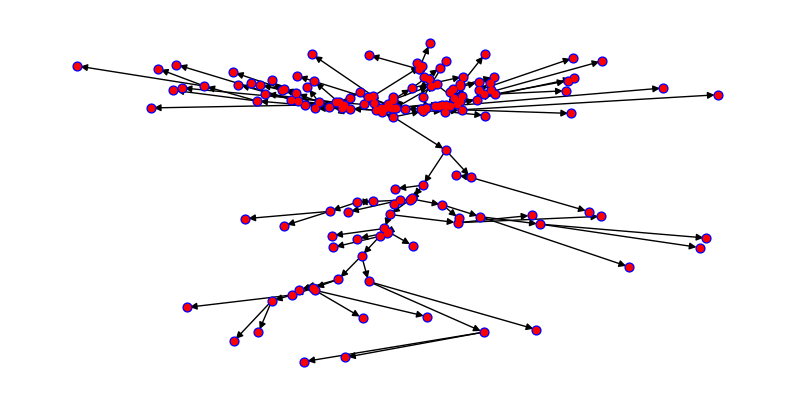

In [345]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

neuron_swc_reader(fname)
solve_graph_neuron = neuron_solve_graph(ncomp=1)

swc_jaxley = graph_io_new.swc_to_nx(fname)
comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)

comp_graph_jaxley = match_nodes(comp_graph_jaxley, solve_graph_neuron, match_on="xyz", tol=1e-3, assert_unique=False)
shared_nodes = set(comp_graph_jaxley.nodes()) & set(solve_graph_neuron.nodes())

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
graph_vis(comp_graph_jaxley.subgraph(shared_nodes), ax=ax, node_size=40, node_color="b")
graph_vis(solve_graph_neuron, ax=ax, node_size=20, node_color="r")

diff_nodes = {}
for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(comp_graph_jaxley.subgraph(shared_nodes), solve_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all), f"|{key}-{key}'| > {1e-5} for some nodes")
    d = compare_node_attrs(comp_graph_jaxley, solve_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=None, subset=shared_nodes)
    diff_nodes[key] = [k for k, v in d.items() if not v]

graph_vis(solve_graph_neuron.subgraph(diff_nodes["x"]), ax=ax, node_size=50, node_color="g")
# ax.set_xlim(-50, -10)
# ax.set_ylim(-500, -300)

In [ ]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

neuron_swc_reader(fname)
comp_graph_neuron = neuron_comp_graph(ncomp=1)

swc_jaxley = graph_io_new.swc_to_nx(fname)
comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=1, max_len=2000.0, ignore_swc_tracing_interruptions=False)
comp_graph_jaxley = graph_io_new._add_jaxley_meta_data(comp_graph_jaxley)

comp_graph_jaxley = match_nodes(comp_graph_jaxley, comp_graph_neuron, match_on="xyz", tol=1e-3, assert_unique=False)
# comp_graph_jaxley = match_edges(comp_graph_jaxley, comp_graph_neuron, raise_if_not_found=False)

shared_nodes = set(comp_graph_jaxley.nodes()) & set(comp_graph_neuron.nodes())

for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(comp_graph_jaxley, comp_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all, subset=shared_nodes), f"|{key}-{key}'| > {1e-5} for some nodes")

solve_graph_jaxley = graph_io_new._replace_branchpoints_with_edges(comp_graph_jaxley)
# solve_graph_jaxley = match_edges(solve_graph_jaxley, comp_graph_neuron)
# solve_graph_jaxley = match_nodes(solve_graph_jaxley, comp_graph_neuron, match_on="xyz", tol=1e-3)

for key in ["radius", "length", "area", "volume", "x", "y", "z"]:
    print_or_assert(compare_node_attrs(solve_graph_jaxley, comp_graph_neuron, key, func=lambda x, y: jnp.isclose(x, y, atol=1e-5), reduce=jnp.all, subset=shared_nodes), f"|{key}-{key}'| > {1e-5} for some nodes")

# node_match = lambda n1, n2: all(jnp.isclose(n1[k], n2[k], atol=1e-3) or (np.isnan(n1[k]) & np.isnan(n2[k])) for k in ["x", "y", "z", "radius", "length", "area", "volume"])
# nx.is_isomorphic(solve_graph_jaxley, comp_graph_neuron, node_match=node_match)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# graph_vis(solve_graph_jaxley, ax=ax, node_size=40, node_color="b")
# graph_vis(comp_graph_neuron, ax=ax, node_size=20, node_color="r")

# cell_new = graph_io_new._build_module(solve_graph_jaxley)

True

In [ ]:
# bounds = np.linspace(0, 1, sec.nseg+1)
# centers = (bounds[1:] + bounds[:-1]) / 2
# center = centers[np.digitize(loc, bounds) -1]

# n3d = sec.n3d()
# x3d = np.array([sec.x3d(i) for i in range(n3d)])
# y3d = np.array([sec.y3d(i) for i in range(n3d)])
# z3d = np.array([sec.z3d(i) for i in range(n3d)])
# arc = np.array([sec.arc3d(i) for i in range(n3d)])  # Cumulative arc lengths
# r3d = np.array([sec.diam3d(i) / 2 for i in range(n3d)])
# xyzr = np.array([x3d, y3d, z3d, r3d]).T

# seg_x = np.interp(center * arc[-1], arc, x3d)
# seg_y = np.interp(center * arc[-1], arc, y3d)
# seg_z = np.interp(center * arc[-1], arc, z3d)

In [ ]:
from neuron import h

import jaxley as jx
from jaxley.channels import HH

_ = h.load_file("stdlib.hoc")
_ = h.load_file("import3d.hoc")

fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

i_delay = 5.0
i_dur = 20.0
i_amp = 1.0
t_max = 30.0
dt = 0.025

stim_loc = 0.51
loc = 0.51

ncomp_per_branch = 3

##################### NEURON ##################
h.secondorder = 0

for sec in h.allsec():
    h.delete_section(sec=sec)

cell = h.Import3d_SWC_read()
cell.input(fname)
i3d = h.Import3d_GUI(cell, False)
i3d.instantiate(None)

for sec in h.allsec():
    sec.nseg = ncomp_per_branch

pathlengths_neuron = np.asarray([sec.L for sec in h.allsec()])

####################### jaxley ##################
neuron_swc_reader(fname)
comp_graph_neuron = neuron_comp_graph(ncomp=ncomp_per_branch)
cell = graph_io_new._build_module(comp_graph_neuron)

# swc_graph_new = graph_io_new.swc_to_nx(fname)
# comp_graph_new = graph_io_new.build_compartment_graph(swc_graph_new, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
# cell = graph_io_new.from_graph(comp_graph_new)

pathlengths = []
for branch in cell.branches:
    pathlengths.append(branch.nodes["length"].sum())
pathlengths_jaxley = np.asarray(pathlengths)

jaxley_inds = [0, 1, 2, 5, 10, 16, 20, 40, 60, 80]
jaxley_inds = [ind for ind in jaxley_inds if ind < len(pathlengths_jaxley)]

neuron_inds = []
for jaxley_ind in jaxley_inds:
    for i, p in enumerate(pathlengths_jaxley):
        if i == jaxley_ind:
            closest_match = np.argmin(np.abs(pathlengths_neuron - p))
            neuron_inds.append(closest_match)

cell.insert(HH())
cell.set("axial_resistivity", 100.0)
cell.set("v", -62.0)
cell.set("HH_m", 0.074901)
cell.set("HH_h", 0.4889)
cell.set("HH_n", 0.3644787)

jaxley_stim = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.soma.branch(0).loc(stim_loc).stimulate(jaxley_stim)
for i in jaxley_inds:
    cell.branch(i).loc(loc).record(verbose=False)

# voltages_jaxley = jx.integrate(cell, delta_t=dt, voltage_solver="jaxley.dhs.cpu")

################### NEURON #################
stim = h.IClamp(h.soma[0](stim_loc))
stim.delay = i_delay
stim.dur = i_dur
stim.amp = i_amp

counter = 0
voltage_recs = {}

for r in neuron_inds:
    for i, sec in enumerate(h.allsec()):
        if i == r:
            v = h.Vector()
            v.record(sec(loc)._ref_v)
            voltage_recs[f"v{counter}"] = v
            counter += 1

for sec in h.allsec():
    sec.insert("hh")
    sec.Ra = 100.0

    sec.gnabar_hh = 0.120  # S/cm2
    sec.gkbar_hh = 0.036  # S/cm2
    sec.gl_hh = 0.0003  # S/cm2
    sec.ena = 50  # mV
    sec.ek = -77.0  # mV
    sec.el_hh = -54.3  # mV

h.dt = dt
tstop = t_max
v_init = -62.0

def initialize():
    h.finitialize(v_init)
    h.fcurrent()

def integrate():
    while h.t < tstop:
        h.fadvance()

initialize()
integrate()
voltages_neuron = np.asarray([voltage_recs[key] for key in voltage_recs])
errors = np.mean(np.abs(voltages_jaxley - voltages_neuron), axis=1)

Added 1 external_states. See `.externals` for details.


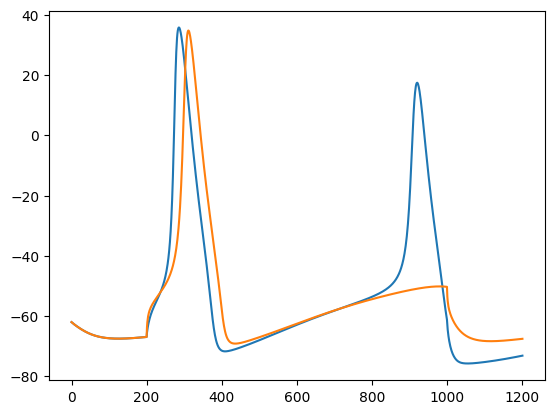

In [342]:
plt.plot(voltages_neuron[0], label="neuron")
# plt.plot(voltages_jaxley_old[0], label="jaxley old")
plt.plot(voltages_jaxley[0], label="new")

Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.
Added 1 external_states. See `.externals` for details.


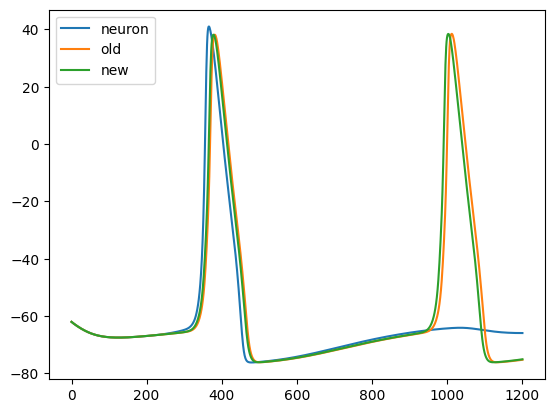

In [276]:
fname = "../jaxley/tests/swc_files/morph_ca1_n120.swc"

ncomp_per_branch = 3

neuron_swc_reader(fname)
comp_graph_neuron = neuron_comp_graph(ncomp=ncomp_per_branch)
cell_neuron = graph_io_new._build_module(comp_graph_neuron)

swc_graph_new = graph_io_new.swc_to_nx(fname)
comp_graph_new = graph_io_new.build_compartment_graph(swc_graph_new, ncomp=ncomp_per_branch, max_len=2_000.0, ignore_swc_tracing_interruptions=False)
cell_new = graph_io_new.from_graph(comp_graph_new)

cell_old = jx.read_swc(
    fname,
    ncomp=ncomp_per_branch,
    max_branch_len=2_000.0,
    assign_groups=True,
    backend="graph",
    ignore_swc_tracing_interruptions=False,
)

loc = 0.51
rec_inds = [0, 1, 2, 5, 10, 16, 20, 40, 60, 80]
rec_xyz = np.concatenate([cell_old.branch(i).loc(loc).nodes[["x", "y", "z"]].values for i in rec_inds])

stim_loc = 0.51
stim_xyz = cell_old.soma.branch(0).loc(stim_loc).nodes[["x", "y", "z"]].values
stimulus = jx.step_current(i_delay = 5.0, i_dur = 20.0, i_amp = 1.0, delta_t = 0.025, t_max = 30.0)

for cell in [cell_old, cell_neuron, cell_new]:
    cell.insert(HH())
    cell.set("axial_resistivity", 100.0)
    cell.set("v", -62.0)
    cell.set("HH_m", 0.074901)
    cell.set("HH_h", 0.4889)
    cell.set("HH_n", 0.3644787)

    xyzs = cell.nodes[["x", "y", "z"]].values
    dists = cdist(xyzs, stim_xyz)
    idx = np.argmin(dists, axis=0)
    cell.select(idx).stimulate(stimulus)

    dists = cdist(xyzs, rec_xyz)
    rec_idxs = np.argmin(dists, axis=0)
    for i in rec_idxs:
        cell.select(i).record(verbose=False)

voltages_neuron = jx.integrate(cell_neuron, delta_t=dt, voltage_solver="jaxley.dhs.cpu")
voltages_old = jx.integrate(cell_old, delta_t=dt, voltage_solver="jaxley.dhs.cpu")
voltages_new = jx.integrate(cell_new, delta_t=dt, voltage_solver="jaxley.dhs.cpu")

plt.plot(voltages_neuron[0], label="neuron")
plt.plot(voltages_old[0], label="old")
plt.plot(voltages_new[0], label="new")
plt.legend()

In [1569]:
fpath = "../jaxley/tests/swc_files"
fname = "morph_ca1_n120_250.swc"

swc_jaxley = graph_io_new.swc_to_nx(os.path.join(fpath, fname))

comp_graph_jaxley = graph_io_new.build_compartment_graph(swc_jaxley, ncomp=3, max_len=2000.0, ignore_swc_tracing_interruptions=False)
# cell = graph_io_new.from_graph(comp_graph_jaxley)


In [ ]:
def to_graph(module):
    edges = module.edges.set_index(["pre_index", "post_index"])
    edges.index.names = (None, None)

    G = graph_io_new.pandas_to_nx(module.nodes, edges, pd.Series())

    global_attrs = ["xyzr", "channels", "synapses", "group_names", "branchpoints_and_tips"]
    for attr in global_attrs:
        G.graph[attr] = getattr(module, attr)

    G = graph_io_new._replace_edges_with_branchpoints(G) # TODO: fix this
    return G

def set_ncomp(cell, branch, ncomp):
    branch_xyzr = cell.xyzr[branch]
    node_df = pd.DataFrame(branch_xyzr, columns=["x", "y", "z", "r"])
    node_df["id"] = 0 # dummy id

    # assert no synapses attached to branch
    # assert attrs other than xyzr along branch are the same

    branch_comps = graph_io_new.compartmentalize_branch(node_df, ncomp)
    # TODO: Finish this

In [ ]:
def set_ncomp(view, ncomp):
    from jaxley.io.graph import branch_comps_from_nodes

    new_branch_comps = []
    for branch_idx in view._branches_in_view:
        branch = view.branch(branch_idx)
        node_attrs = pd.DataFrame(branch.xyzr[0], columns=["x", "y", "z", "r"])
        node_attrs["id"] = 0
        new_comps = branch_comps_from_nodes(node_attrs, ncomp)
        comp_cols = ["is_comp","id", "length", "x", "y", "z", "radius", "area", "volume"]
        comp_df = pd.DataFrame(new_comps, columns=comp_cols)
        comp_df = comp_df.loc[comp_df["is_comp"].astype(bool)].drop(columns=["id", "is_comp"])
        
        for name, is_group in branch.nodes[branch.group_names].all().items():
            comp_df.loc[:, name] = is_group

        comp_df["global_cell_index"] = branch.nodes["global_cell_index"].iloc[0]
        comp_df["global_branch_index"] = branch.nodes["global_branch_index"].iloc[0]
        comp_df["v"] = np.mean(branch.nodes["v"])
        comp_df["axial_resistivity"] = np.mean(branch.nodes["axial_resistivity"])
        comp_df["capacitance"] = np.mean(branch.nodes["capacitance"])
            
        comp_df.index = [-1]*len(comp_df.index)

        new_branch_comps.append(comp_df)

    for branch_idx, branch_comps in zip(view._branches_in_view, new_branch_comps):
        branch_nodes = view.nodes[view.nodes["global_branch_index"] == branch_idx].index
        view.base.nodes = pd.concat([view.base.nodes.loc[:branch_nodes[0]], branch_comps, view.base.nodes.loc[branch_nodes[-1]:]], ignore_index=True, join="outer")
    
    view.base.nodes["global_comp_index"] = np.arange(len(view.base.nodes))
    view.base._init_view()
    view.base._update_local_indices()
    

set_ncomp(cell.branch(0), 5)

In [640]:
swc_graph_old = graph_io_old.to_swc_graph(fname)
comp_graph_old = graph_io_old.build_compartment_graph(swc_graph_old, ncomp=1, max_len=1e-10)
test_cell = graph_io_old.from_graph(comp_graph_old)


In [641]:
print(len(swc_graph_old.nodes))
print(len(test_cell.nodes))

250
249
